First of all let's import necessery libraries.

In [71]:
!pip install bs4
!conda install -c conda-forge folium=0.5.0 --yes
!pip install wordcloud
!pip install geopy

Solving environment: done

# All requested packages already installed.



In [72]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import json
import folium
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from wordcloud import WordCloud, STOPWORDS
from sklearn import preprocessing

Will use information about Los Angeles neighborhoods from Wikipedia.

In [73]:
url1 = 'http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_LA_Neighborhoods_Data'
df1 = pd.read_html(url1, flavor='bs4')[2]
df1.head()

,LA_Nbhd,Income,Schools,Diversity,Age,Homes,Vets,Asian,Black,Latino,White,Population,Area,Longitude,Latitude
0,Adams_Normandie,29606,691,0.6,26,0.26,0.05,0.05,0.25,0.62,0.06,31068,0.8,-118.300270,34.030970
1,Arleta,65649,719,0.4,29,0.29,0.07,0.11,0.02,0.72,0.13,31068,3.1,-118.430015,34.240603
2,Arlington_Heights,31423,687,0.8,31,0.31,0.05,0.13,0.25,0.57,0.05,22106,1.0,-118.320109,34.043611
3,Atwater_Village,53872,762,0.9,34,0.34,0.06,0.20,0.01,0.51,0.22,14888,1.8,-118.265808,34.124908
4,Baldwin_Hills/Crenshaw,37948,656,0.4,36,0.36,0.10,0.05,0.71,0.17,0.03,30123,3.0,-118.366700,34.019090


Will clean the table: drop / rename some columns and values.

In [74]:
neighborhoods = pd.DataFrame([df1.LA_Nbhd, df1.Income, df1.Longitude, df1.Latitude]).transpose()
neighborhoods.rename(columns={'LA_Nbhd':'Neighborhood'}, inplace=True)
neighborhoods['Neighborhood'] = neighborhoods['Neighborhood'].str.replace('_',' ')
neighborhoods['Neighborhood'] = neighborhoods['Neighborhood'].str.replace('/',' / ')
print('There are ', neighborhoods['Neighborhood'].count(), ' neighborhoods in LA:')
neighborhoods.head()

There are  110  neighborhoods in LA:


,Neighborhood,Income,Longitude,Latitude
0,Adams Normandie,29606,-118.3,34.031
1,Arleta,65649,-118.43,34.2406
2,Arlington Heights,31423,-118.32,34.0436
3,Atwater Village,53872,-118.266,34.1249
4,Baldwin Hills / Crenshaw,37948,-118.367,34.0191


Let's get Los Angeles neighborhoods Crime data.

In [115]:
url2 = 'http://maps.latimes.com/neighborhoods/property-crime/neighborhood/list/'
df2 = pd.read_html(url2, flavor='bs4')[3]
df2.head()

,Rank,Neighborhood,Per Capita,Total
0,1,Elysian Park,263.2,70
1,2,Fairfax,251.5,336
2,3,Beverly Grove,243.3,556
3,4,Playa Vista,231.3,139
4,5,Rancho Park,199.7,91


Will use geopy library to get the latitude and longitude values of Los Angeles.

In [76]:
address = 'Los Angeles, LA'
geolocator = Nominatim(user_agent="LA_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Los Angeles are 34.0536909, -118.242766.


Folium is a great visualization library. We can zoom into the below map, and click on each circle mark to reveal the name of the neighborhood.

In [77]:
# create map of Los Angeles using latitude and longitude values
map_LA = folium.Map(location=[latitude, longitude], zoom_start=9)

# will add markers to map
for lat, lng, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA)  

# will show the map
print('This is a map of Los Angeles neighburhoods')
map_LA

This is a map of Los Angeles neighburhoods


Will define Foursquare Credentials and Version below (sensitive code cell).

In [78]:
CLIENT_ID = 'LNCKLABY1DEZOJNPD0JA200QJDKCGOLCDMJUW2NA010RCDVA'
CLIENT_SECRET = 'EYRFXSLVQPKBD54I5C2V0O4BJKSE52G5RVODPMEII4FADD40'
VERSION = '20210313' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Let's create a function returns venues in 500m from Foursquare to all the neighborhoods in Los Angeles.

In [79]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url3 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url3).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's create a dataframe of Los Angeles venues and see how many of them were returned:

In [80]:
LA_venues = getNearbyVenues(names = neighborhoods['Neighborhood'],
                                   latitudes = neighborhoods['Latitude'],
                                   longitudes = neighborhoods['Longitude']
                                  )
LA_venues.groupby('Neighborhood').count()

Adams Normandie
Arleta
Arlington Heights
Atwater Village
Baldwin Hills / Crenshaw
Bel-Air
Beverly Crest
Beverly Grove
Beverlywood
Boyle Heights
Brentwood
Broadway Manchester
Canoga Park
Carthay
Central Alameda
Century City
Chatsworth
Chesterfield Square
Cheviot Hills
Chinatown
Cypress Park
Del Rey
Downtown
Eagle Rock
East Hollywood
Echo Park
El Sereno
Elysian Park
Elysian Valley
Encino
Exposition Park
Fairfax
Florence
Glassell Park
Gramercy Park
Granada Hills
Green Meadows
Hancock Park
Harbor City
Harbor Gateway
Harvard Heights
Harvard Park
Highland Park
Historic South Central
Hollywood
Hollywood Hills
Hollywood Hills West
Hyde Park
Jefferson Park
Koreatown
Lake Balboa
Lake View Terrace
Larchmont
Leimert Park
Lincoln Heights
Los Feliz
Manchester Square
Mar Vista
Mid City
Mid Wilshire
Mission Hills
Montecito Heights
Mount Washington
North Hills
North Hollywood
Northridge
Pacific Palisades
Pacoima
Palms
Panorama City
Pico Robertson
Pico Union
Playa del Rey
Playa Vista
Porter Ranch
Rancho

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adams Normandie,9,9,9,9,9,9
Arleta,5,5,5,5,5,5
Arlington Heights,8,8,8,8,8,8
Atwater Village,40,40,40,40,40,40
Baldwin Hills / Crenshaw,2,2,2,2,2,2
...,...,...,...,...,...,...
Westchester,6,6,6,6,6,6
Westlake,53,53,53,53,53,53
Wilmington,14,14,14,14,14,14


Let's find out how many unique categories can be curated from all the returned venues.

In [81]:
print('There are {} uniques categories.'.format(len(LA_venues['Venue Category'].unique())))

There are 267 uniques categories.


In [82]:
# one hot encoding
LA_onehot = pd.get_dummies(LA_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
LA_onehot['Neighborhood'] = LA_venues['Neighborhood'] 

# move neighbourhood column to the first column
fixed_columns = [LA_onehot.columns[-1]] + list(LA_onehot.columns[:-1])
LA_onehot = LA_onehot[fixed_columns]

LA_onehot.head()

,Yoga Studio,ATM,Accessories Store,Adult Boutique,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Watch Shop,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category.

In [83]:
LA_grouped = LA_onehot.groupby('Neighborhood').mean().reset_index()
LA_grouped.head()

,Neighborhood,Yoga Studio,ATM,Accessories Store,Adult Boutique,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Watch Shop,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Adams Normandie,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Arleta,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arlington Heights,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Atwater Village,0.0,0.0,0.0,0.0,0.025,0.0,0.0,0.0,0.0,...,0.0,0.0,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Baldwin Hills / Crenshaw,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's write a function to sort the venues in descending order:


In [84]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Let's create a dataframe with the top 10 venues for each neighborhood.

In [85]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = LA_grouped['Neighborhood']

for ind in np.arange(LA_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(LA_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams Normandie,Sushi Restaurant,Gas Station,Park,Grocery Store,Playground,Taco Place,Latin American Restaurant,Women's Store,Ethiopian Restaurant,Event Service
1,Arleta,Bakery,Flower Shop,Convenience Store,Historic Site,Video Store,Farm,Escape Room,Ethiopian Restaurant,Event Service,Fabric Shop
2,Arlington Heights,Seafood Restaurant,Shop & Service,Grocery Store,Rental Car Location,Restaurant,Donut Shop,Café,Escape Room,Women's Store,Event Service
3,Atwater Village,Food Truck,Mobile Phone Shop,Chinese Restaurant,Fast Food Restaurant,Ice Cream Shop,Diner,Steakhouse,Spa,Shoe Store,Coffee Shop
4,Baldwin Hills / Crenshaw,Flower Shop,Clothing Store,Women's Store,Escape Room,Food Stand,Food Service,Food Court,Food,Filipino Restaurant,Fast Food Restaurant


We are going to cluster Los Angeles neighborhoods using a k-means method.
Let's use an Elbow Method to find out, how many cluster we should use:

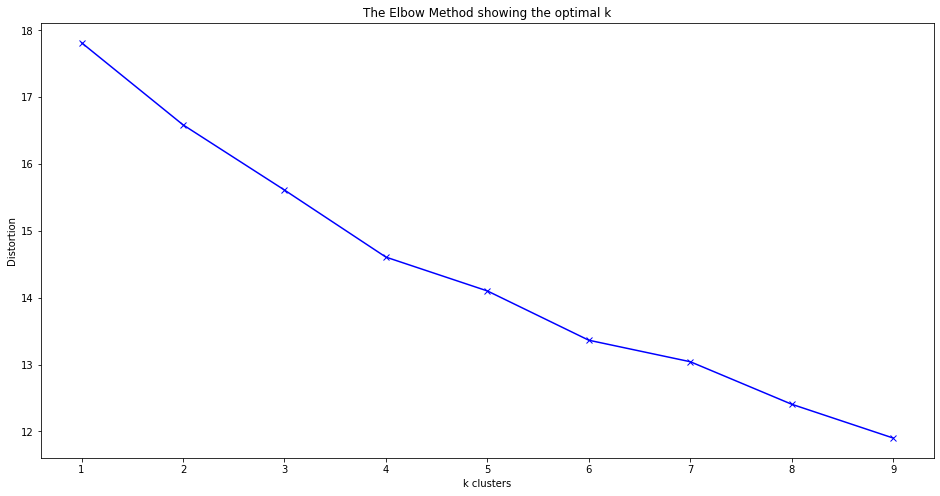

In [86]:
LA_grouped_clustering = LA_grouped.drop('Neighborhood',1)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(LA_grouped_clustering)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

So I will run k-means to cluster the neighborhood into 4 clusters.

In [87]:
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(LA_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [88]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

LA_merged = neighborhoods

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
LA_merged = LA_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

LA_merged.head() # check the last columns!

,Neighborhood,Income,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams Normandie,29606,-118.3,34.031,1.0,Sushi Restaurant,Gas Station,Park,Grocery Store,Playground,Taco Place,Latin American Restaurant,Women's Store,Ethiopian Restaurant,Event Service
1,Arleta,65649,-118.43,34.2406,1.0,Bakery,Flower Shop,Convenience Store,Historic Site,Video Store,Farm,Escape Room,Ethiopian Restaurant,Event Service,Fabric Shop
2,Arlington Heights,31423,-118.32,34.0436,1.0,Seafood Restaurant,Shop & Service,Grocery Store,Rental Car Location,Restaurant,Donut Shop,Café,Escape Room,Women's Store,Event Service
3,Atwater Village,53872,-118.266,34.1249,1.0,Food Truck,Mobile Phone Shop,Chinese Restaurant,Fast Food Restaurant,Ice Cream Shop,Diner,Steakhouse,Spa,Shoe Store,Coffee Shop
4,Baldwin Hills / Crenshaw,37948,-118.367,34.0191,1.0,Flower Shop,Clothing Store,Women's Store,Escape Room,Food Stand,Food Service,Food Court,Food,Filipino Restaurant,Fast Food Restaurant


Let's check if the neighborhoods got no venues returned form Foursquare and drop them if there is any.

In [89]:
is_NaN = LA_merged.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = LA_merged[row_has_NaN]
print(rows_with_NaN)

       Neighborhood Income Longitude Latitude  Cluster Labels  \
105        Westwood  68716  -118.433  34.0673             NaN   
107  Windsor Square  61767  -118.319   34.069             NaN   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
105                   NaN                   NaN                   NaN   
107                   NaN                   NaN                   NaN   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
105                   NaN                   NaN                   NaN   
107                   NaN                   NaN                   NaN   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
105                   NaN                   NaN                   NaN   
107                   NaN                   NaN                   NaN   

    10th Most Common Venue  
105                    NaN  
107                    NaN  


In [90]:
LA_merged.dropna(inplace=True)

In [91]:
LA_merged['Cluster Labels'] = LA_merged['Cluster Labels'].astype(int)

Finally, let's visualize the resulting clusters!

In [92]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(LA_merged['Latitude'], LA_merged['Longitude'], LA_merged['Neighborhood'], LA_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's examine each cluster and determine the discriminating venue categories that distinguish each cluster:

In [93]:
LA_merged.loc[LA_merged['Cluster Labels'] == 0, LA_merged.columns[[0] + list(range(4, LA_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Central Alameda,0,Park,Clothing Store,Women's Store,Food Service,Food Court,Food,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market
41,Harvard Park,0,Burger Joint,Park,Food Stand,Food Service,Food Court,Food,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market
50,Lake Balboa,0,Park,Steakhouse,Food Stand,Food Service,Food Court,Food,Flower Shop,Filipino Restaurant,Empanada Restaurant,Farmers Market
51,Lake View Terrace,0,Park,Farm,Stables,Department Store,Design Studio,Food Stand,Food Service,Food Court,Food,Flower Shop
61,Montecito Heights,0,Lake,Park,Women's Store,Farmers Market,Ethiopian Restaurant,Event Service,Fabric Shop,Falafel Restaurant,Farm,Fast Food Restaurant
82,South Park,0,Park,Bakery,Video Store,Shopping Mall,Grocery Store,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Farm,Electronics Store


In [94]:
LA_merged.loc[LA_merged['Cluster Labels'] == 1, LA_merged.columns[[0] + list(range(4, LA_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams Normandie,1,Sushi Restaurant,Gas Station,Park,Grocery Store,Playground,Taco Place,Latin American Restaurant,Women's Store,Ethiopian Restaurant,Event Service
1,Arleta,1,Bakery,Flower Shop,Convenience Store,Historic Site,Video Store,Farm,Escape Room,Ethiopian Restaurant,Event Service,Fabric Shop
2,Arlington Heights,1,Seafood Restaurant,Shop & Service,Grocery Store,Rental Car Location,Restaurant,Donut Shop,Café,Escape Room,Women's Store,Event Service
3,Atwater Village,1,Food Truck,Mobile Phone Shop,Chinese Restaurant,Fast Food Restaurant,Ice Cream Shop,Diner,Steakhouse,Spa,Shoe Store,Coffee Shop
4,Baldwin Hills / Crenshaw,1,Flower Shop,Clothing Store,Women's Store,Escape Room,Food Stand,Food Service,Food Court,Food,Filipino Restaurant,Fast Food Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...
103,Westlake,1,Sandwich Place,Mexican Restaurant,Pharmacy,Paper / Office Supplies Store,Pizza Place,Thai Restaurant,Coffee Shop,Bakery,Bank,Furniture / Home Store
104,West Los Angeles,1,Clothing Store,Fast Food Restaurant,Asian Restaurant,Bed & Breakfast,Sandwich Place,Grocery Store,Donut Shop,Coffee Shop,Supermarket,Thai Restaurant
106,Wilmington,1,Grocery Store,Burger Joint,Seafood Restaurant,Mobile Phone Shop,Pizza Place,Chinese Restaurant,Discount Store,Pharmacy,Video Store,Bank
108,Winnetka,1,Ice Cream Shop,Latin American Restaurant,Food,Fried Chicken Joint,South American Restaurant,Filipino Restaurant,Mexican Restaurant,Grocery Store,Bar,Home Service


In [95]:
LA_merged.loc[LA_merged['Cluster Labels'] == 2, LA_merged.columns[[0] + list(range(4, LA_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Beverly Crest,2,Food Truck,Women's Store,Escape Room,Food Stand,Food Service,Food Court,Food,Flower Shop,Filipino Restaurant,Fast Food Restaurant


In [96]:
LA_merged.loc[LA_merged['Cluster Labels'] == 3, LA_merged.columns[[0] + list(range(4, LA_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
79,Shadow Hills,3,Stables,Empanada Restaurant,Food Stand,Food Service,Food Court,Food,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market


Let's put all top 10 most common venues of neighborhoods in cluster 1 together, to se what categories are the most popular.

In [97]:
cluster1 = LA_merged.loc[LA_merged['Cluster Labels'] == 1]
most_common_venues = cluster1[["1st Most Common Venue", "2nd Most Common Venue", "3rd Most Common Venue",
                          "4th Most Common Venue", "5th Most Common Venue", "6th Most Common Venue", 
                          "7th Most Common Venue", "8th Most Common Venue", "9th Most Common Venue", 
                          "10th Most Common Venue", ]]
most_common_venues.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Sushi Restaurant,Gas Station,Park,Grocery Store,Playground,Taco Place,Latin American Restaurant,Women's Store,Ethiopian Restaurant,Event Service
1,Bakery,Flower Shop,Convenience Store,Historic Site,Video Store,Farm,Escape Room,Ethiopian Restaurant,Event Service,Fabric Shop
2,Seafood Restaurant,Shop & Service,Grocery Store,Rental Car Location,Restaurant,Donut Shop,Café,Escape Room,Women's Store,Event Service
3,Food Truck,Mobile Phone Shop,Chinese Restaurant,Fast Food Restaurant,Ice Cream Shop,Diner,Steakhouse,Spa,Shoe Store,Coffee Shop
4,Flower Shop,Clothing Store,Women's Store,Escape Room,Food Stand,Food Service,Food Court,Food,Filipino Restaurant,Fast Food Restaurant


Will put it in a list:

In [119]:
text = most_common_venues.values
venues = np.array_str(text)
venues

'[[\'Sushi Restaurant\' \'Gas Station\' \'Park\' \'Grocery Store\' \'Playground\'\n  \'Taco Place\' \'Latin American Restaurant\' "Women\'s Store"\n  \'Ethiopian Restaurant\' \'Event Service\']\n [\'Bakery\' \'Flower Shop\' \'Convenience Store\' \'Historic Site\'\n  \'Video Store\' \'Farm\' \'Escape Room\' \'Ethiopian Restaurant\'\n  \'Event Service\' \'Fabric Shop\']\n [\'Seafood Restaurant\' \'Shop & Service\' \'Grocery Store\'\n  \'Rental Car Location\' \'Restaurant\' \'Donut Shop\' \'Café\' \'Escape Room\'\n  "Women\'s Store" \'Event Service\']\n [\'Food Truck\' \'Mobile Phone Shop\' \'Chinese Restaurant\'\n  \'Fast Food Restaurant\' \'Ice Cream Shop\' \'Diner\' \'Steakhouse\' \'Spa\'\n  \'Shoe Store\' \'Coffee Shop\']\n [\'Flower Shop\' \'Clothing Store\' "Women\'s Store" \'Escape Room\'\n  \'Food Stand\' \'Food Service\' \'Food Court\' \'Food\' \'Filipino Restaurant\'\n  \'Fast Food Restaurant\']\n [\'Scenic Lookout\' \'Dive Bar\' "Women\'s Store" \'Farm\'\n  \'Ethiopian Restaura

In [146]:
text = most_common_venues.values
venues = np.array_str(text)
venues = venues.replace("\n", "")
venues = venues.replace("/", "")
venues = venues.replace("[", "")
venues = venues.replace("]", "")
venues = venues.replace("...", "")
venues = venues.replace("  ", " ")
venues = venues.replace("'", "")
venues

'Sushi Restaurant Gas Station Park Grocery Store Playground Taco Place Latin American Restaurant "Womens Store" Ethiopian Restaurant Event Service Bakery Flower Shop Convenience Store Historic Site Video Store Farm Escape Room Ethiopian Restaurant Event Service Fabric Shop Seafood Restaurant Shop & Service Grocery Store Rental Car Location Restaurant Donut Shop Café Escape Room "Womens Store" Event Service Food Truck Mobile Phone Shop Chinese Restaurant Fast Food Restaurant Ice Cream Shop Diner Steakhouse Spa Shoe Store Coffee Shop Flower Shop Clothing Store "Womens Store" Escape Room Food Stand Food Service Food Court Food Filipino Restaurant Fast Food Restaurant Scenic Lookout Dive Bar "Womens Store" Farm Ethiopian Restaurant Event Service Fabric Shop Falafel Restaurant Farmers Market Empanada Restaurant Clothing Store Juice Bar Cosmetics Shop Chinese Restaurant Vegetarian Vegan Restaurant Mexican Restaurant Lingerie Store Sushi Restaurant Café Seafood Restaurant Park Dessert Shop Bo

Now let's see the most popular categories in a Word Cloud.

(-0.5, 999.5, 499.5, -0.5)

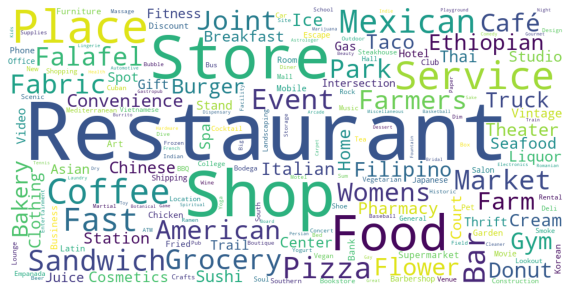

In [154]:
wordcloud = WordCloud(background_color = "white", collocations=False, width = 1000, height = 500).generate(venues)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis("off")

Let's se how many Restaurants we can find in every neighborhood among 10 most common venues.

In [155]:
LA_merged['Restaurants'] = LA_merged['1st Most Common Venue'].str.contains('Restaurant', regex=False).astype(int) +\
LA_merged['2nd Most Common Venue'].str.contains('Restaurant', regex=False).astype(int) +\
LA_merged['3rd Most Common Venue'].str.contains('Restaurant', regex=False).astype(int) +\
LA_merged['4th Most Common Venue'].str.contains('Restaurant', regex=False).astype(int) +\
LA_merged['5th Most Common Venue'].str.contains('Restaurant', regex=False).astype(int) +\
LA_merged['6th Most Common Venue'].str.contains('Restaurant', regex=False).astype(int) +\
LA_merged['7th Most Common Venue'].str.contains('Restaurant', regex=False).astype(int) +\
LA_merged['8th Most Common Venue'].str.contains('Restaurant', regex=False).astype(int) +\
LA_merged['9th Most Common Venue'].str.contains('Restaurant', regex=False).astype(int) +\
LA_merged['10th Most Common Venue'].str.contains('Restaurant', regex=False).astype(int)

In [156]:
LA_merged.head()

,Neighborhood,Income,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Restaurants
68,Palms,50684,-118.402,34.0228,1,Thai Restaurant,Coffee Shop,Mediterranean Restaurant,Mexican Restaurant,Gym,Burger Joint,Theater,Indian Restaurant,Cuban Restaurant,Italian Restaurant,6
7,Beverly Grove,63039,-118.372,34.076,1,Clothing Store,Juice Bar,Cosmetics Shop,Chinese Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant,Lingerie Store,Sushi Restaurant,Café,Seafood Restaurant,5
109,Woodland Hills,89946,-118.606,34.1685,1,Sushi Restaurant,Ice Cream Shop,Mediterranean Restaurant,Burger Joint,Shipping Store,Chinese Restaurant,Pharmacy,Bagel Shop,Indian Restaurant,Mexican Restaurant,5
29,Encino,78529,-118.493,34.1537,1,Shipping Store,American Restaurant,Mexican Restaurant,Clothing Store,Salon / Barbershop,Coffee Shop,Sushi Restaurant,Seafood Restaurant,Bank,Bakery,4
21,Del Rey,63317,-118.423,33.9888,1,Mexican Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Sushi Restaurant,Sandwich Place,Coffee Shop,Latin American Restaurant,Bus Station,Bakery,Donut Shop,4


Let's check if there is relationship between number of Restaurants and Income rate of neighborhood.

In [157]:
x =LA_merged[['Restaurants', 'Income']].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized = pd.DataFrame(x_scaled)
normalized.columns=['restaurants', 'income']
normalized.head()

,restaurants,income
0,1.000000,0.184057
1,0.833333,0.247790
2,0.833333,0.386587
3,0.666667,0.327693
4,0.666667,0.249224


In [158]:
pearsoncorr = normalized.corr(method='pearson')
pearsoncorr

,restaurants,income
restaurants,1.000000,-0.012711
income,-0.012711,1.000000


In [159]:
LA_merged.sort_values(by='Restaurants', ascending=False, inplace=True)
LA_merged.head(107)

,Neighborhood,Income,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Restaurants
68,Palms,50684,-118.402,34.0228,1,Thai Restaurant,Coffee Shop,Mediterranean Restaurant,Mexican Restaurant,Gym,Burger Joint,Theater,Indian Restaurant,Cuban Restaurant,Italian Restaurant,6
109,Woodland Hills,89946,-118.606,34.1685,1,Sushi Restaurant,Ice Cream Shop,Mediterranean Restaurant,Burger Joint,Shipping Store,Chinese Restaurant,Pharmacy,Bagel Shop,Indian Restaurant,Mexican Restaurant,5
7,Beverly Grove,63039,-118.372,34.076,1,Clothing Store,Juice Bar,Cosmetics Shop,Chinese Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant,Lingerie Store,Sushi Restaurant,Café,Seafood Restaurant,5
29,Encino,78529,-118.493,34.1537,1,Shipping Store,American Restaurant,Mexican Restaurant,Clothing Store,Salon / Barbershop,Coffee Shop,Sushi Restaurant,Seafood Restaurant,Bank,Bakery,4
49,Koreatown,30558,-118.301,34.0638,1,Korean Restaurant,Coffee Shop,Asian Restaurant,Hotel,Ice Cream Shop,Bakery,Seafood Restaurant,Mobile Phone Shop,Café,Restaurant,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Vermont Knolls,27730,-118.287,33.9653,1,Grocery Store,Hotel,Sandwich Place,Burger Joint,ATM,Deli / Bodega,Escape Room,Food Stand,Food Service,Food Court,0
78,Sawtelle,57710,-118.463,34.0306,1,Park,Café,Food Truck,Yoga Studio,Gym,Recording Studio,Office,Music Venue,Movie Theater,Theater,0
70,Pico Robertson,63356,-118.245,34.0544,1,Theater,Concert Hall,Park,Lounge,Garden,Opera House,Sandwich Place,General Entertainment,Gift Shop,Building,0
27,Elysian Park,28263,-118.25,34.0825,1,Furniture / Home Store,Grocery Store,Yoga Studio,Juice Bar,Spa,Café,Gift Shop,Scenic Lookout,Park,Trail,0


Will include this Crime data to our main neighborhoods table.

In [160]:
inc_crime = pd.merge(LA_merged, df2, on='Neighborhood')
inc_crime.head()

,Neighborhood,Income,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Restaurants,Rank,Per Capita,Total
0,Palms,50684,-118.402,34.0228,1,Thai Restaurant,Coffee Shop,Mediterranean Restaurant,Mexican Restaurant,Gym,Burger Joint,Theater,Indian Restaurant,Cuban Restaurant,Italian Restaurant,6,65,100.5,457
1,Woodland Hills,89946,-118.606,34.1685,1,Sushi Restaurant,Ice Cream Shop,Mediterranean Restaurant,Burger Joint,Shipping Store,Chinese Restaurant,Pharmacy,Bagel Shop,Indian Restaurant,Mexican Restaurant,5,30,134.7,854
2,Beverly Grove,63039,-118.372,34.076,1,Clothing Store,Juice Bar,Cosmetics Shop,Chinese Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant,Lingerie Store,Sushi Restaurant,Café,Seafood Restaurant,5,3,243.3,556
3,Encino,78529,-118.493,34.1537,1,Shipping Store,American Restaurant,Mexican Restaurant,Clothing Store,Salon / Barbershop,Coffee Shop,Sushi Restaurant,Seafood Restaurant,Bank,Bakery,4,64,100.7,449
4,Koreatown,30558,-118.301,34.0638,1,Korean Restaurant,Coffee Shop,Asian Restaurant,Hotel,Ice Cream Shop,Bakery,Seafood Restaurant,Mobile Phone Shop,Café,Restaurant,4,68,99.6,1238


In [161]:
inc_crime["Income"] = inc_crime["Income"].apply(pd.to_numeric)
inc_crime.dtypes

Neighborhood               object
Income                      int64
Longitude                  object
Latitude                   object
Cluster Labels              int64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
Restaurants                 int64
Rank                        int64
Per Capita                float64
Total                       int64
dtype: object

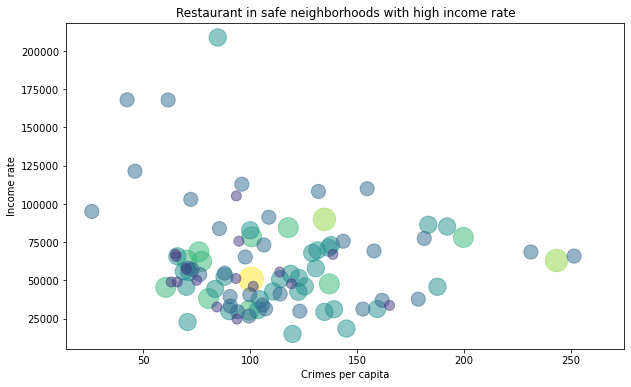

In [163]:
colors=inc_crime['Restaurants']
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x=inc_crime['Per Capita'], y=inc_crime['Income'], s=inc_crime['Restaurants']*100, alpha=0.5, c=colors)
plt.title('Restaurant in safe neighborhoods with high income rate')
plt.xlabel('Crimes per capita')
plt.ylabel('Income rate')
plt.show()

In [205]:
recommendation_raw = inc_crime[((inc_crime['Per Capita'] < 150) & (inc_crime['Restaurants'] >= 4))]
high_income = inc_crime[(inc_crime['Income']>200000)]
recommendation = high_income.append(recommendation_raw)
recommendation = recommendation.drop(columns=['Longitude', 'Latitude', 'Cluster Labels', 'Rank', 'Total'])
recommendation.sort_values(['Restaurants', 'Income'], ascending=[False, False], inplace=True)
recommendation.reset_index(drop=True, inplace=True)
recommendation

,Neighborhood,Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Restaurants,Per Capita
0,Palms,50684,Thai Restaurant,Coffee Shop,Mediterranean Restaurant,Mexican Restaurant,Gym,Burger Joint,Theater,Indian Restaurant,Cuban Restaurant,Italian Restaurant,6,100.5
1,Woodland Hills,89946,Sushi Restaurant,Ice Cream Shop,Mediterranean Restaurant,Burger Joint,Shipping Store,Chinese Restaurant,Pharmacy,Bagel Shop,Indian Restaurant,Mexican Restaurant,5,134.7
2,Chatsworth,84549,Mexican Restaurant,Gym / Fitness Center,Hotel,Beer Bar,Thai Restaurant,Sushi Restaurant,Fast Food Restaurant,Dry Cleaner,Supermarket,BBQ Joint,4,117.8
3,Encino,78529,Shipping Store,American Restaurant,Mexican Restaurant,Clothing Store,Salon / Barbershop,Coffee Shop,Sushi Restaurant,Seafood Restaurant,Bank,Bakery,4,100.7
4,Sunland,68720,Fast Food Restaurant,Asian Restaurant,Convenience Store,Grocery Store,Sandwich Place,Mexican Restaurant,Pizza Place,Coffee Shop,Farmers Market,Filipino Restaurant,4,76.0
5,Del Rey,63317,Mexican Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Sushi Restaurant,Sandwich Place,Coffee Shop,Latin American Restaurant,Bus Station,Bakery,Donut Shop,4,70.4
6,Winnetka,62535,Ice Cream Shop,Latin American Restaurant,Food,Fried Chicken Joint,South American Restaurant,Filipino Restaurant,Mexican Restaurant,Grocery Store,Bar,Home Service,4,77.3
7,Larchmont,47780,Spa,Park,Indie Movie Theater,American Restaurant,Korean Restaurant,Farmers Market,Ethiopian Restaurant,Event Service,Fabric Shop,Falafel Restaurant,4,137.0
8,Highland Park,45478,Pizza Place,Fast Food Restaurant,Romanian Restaurant,Breakfast Spot,Gourmet Shop,Asian Restaurant,Liquor Store,Grocery Store,Vietnamese Restaurant,Arcade,4,60.5
9,West Adams,38209,Seafood Restaurant,Wine Bar,Sandwich Place,Pizza Place,Food,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Dumpling Restaurant,4,80.5
